In [0]:
import os
import sys
sys.path.append("..")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_loader")

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from data_loader.Nottingham_database_preprocessor import *
from data_loader.Nottingham_database_preprocessor_util import *

In [4]:

def generate_pitchs_octaves_chromas():
    pitches = [i for i in range(-3,128)]
    octaves = [pitch2octave(p) for p in pitches]
    chromas = [pitch2pitchclass(p) for p in pitches]

    print(pitches)
    print(octaves)
    print(chromas)

    pitches_one_hot = [[] for i in range(-3,128)]
    octaves_one_hot = [[] for i in range(-3,128)]
    chromas_one_hot = [[] for i in range(-3,128)]

    for i,_ in enumerate(pitches):
        pitches_one_hot[i] = pitch2onehot(pitches[i])
        octaves_one_hot[i] = octave2onehot(octaves[i])
        chromas_one_hot[i] = pitchclass2onehot(chromas[i])
    return pitches,octaves,chromas,pitches_one_hot,octaves_one_hot,chromas_one_hot

[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
[-3, -2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9]
[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 

In [0]:
class PitchDataset(Dataset):
    def __init__(self,pitches_one_hot,octaves_one_hot,chromas_one_hot):
        self.pitches_one_hot = torch.tensor(pitches_one_hot)
        self.octaves_one_hot = torch.tensor(octaves_one_hot)
        self.chromas_one_hot = torch.tensor(chromas_one_hot)
    def __len__(self):
        return len(self.pitches_one_hot)
    def __getitem__(self, index):
        this_pitch = self.pitches_one_hot[index]
        this_octave = self.octaves_one_hot[index]
        this_chroma = self.chromas_one_hot[index]
        return this_pitch,this_octave,this_chroma

In [0]:
class PitchEncoder(nn.Module):
    def __init__(self, one_hot_size=130, h_dim=40, z_dim=20):
        super(PitchEncoder, self).__init__()
        self.fc1 = nn.Linear(one_hot_size, h_dim)
        self.fc_encoder_mu = nn.Linear(h_dim, z_dim)
        self.fc_encoder_logvar = nn.Linear(h_dim, z_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_encoder_mu(h)
        logvar = self.fc_encoder_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

In [0]:
class PitchDecoder(nn.Module):
    def __init__(self, one_hot_size=130, h_dim=40, z_dim=20):
        super(PitchDecoder, self).__init__()
        self.fc_decoder = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, one_hot_size)
        self.softmax = nn.Softmax()
    
    def forward(self, z):
        h = F.relu(self.fc_decoder(z))
        x_reconst = self.softmax(self.fc2(h))
        return x_reconst

In [0]:
class OctaveClassifier(nn.Module):
    def __init__(self, input_dim=20, hid_dim=40, out_dim=12):
        super(OctaveClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, out_dim)
        #self.fc2 = nn.Linear(hid_dim, out_dim)
        self.softmax = nn.Softmax()
    
    def forward(self, z):
        #hid = self.fc1(z)
        out = self.softmax(self.fc1(z))
        return out

In [0]:
class ChromaClassifier(nn.Module):
    def __init__(self, input_dim=20, hid_dim=40, out_dim=14):
        super(ChromaClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, out_dim)
        #self.fc2 = nn.Linear(hid_dim, out_dim)
        self.softmax = nn.Softmax()
    
    def forward(self, z):
        #hid = self.fc1(z)
        out = self.softmax(self.fc1(z))
        return out

In [0]:
pitch_dataset = PitchDataset(pitches_one_hot[0:10],octaves_one_hot[0:10],chromas_one_hot[0:10])
pitch_dataloader = DataLoader(pitch_dataset, batch_size=1, shuffle=True)
n_epoch = 500

In [0]:
one_hot_size=130
z_dim=10
hid_dim=80
octave_out_dim=12
chroma_out_dim=14

model_PitchEncoder = PitchEncoder(one_hot_size, hid_dim, z_dim).to(device)
model_PitchDecoder = PitchDecoder(one_hot_size, hid_dim, z_dim).to(device)
model_OctaveClassifier = OctaveClassifier(z_dim, hid_dim, octave_out_dim).to(device)
model_ChromaClassifier = ChromaClassifier(z_dim, hid_dim, chroma_out_dim).to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer_PitchEncoder = torch.optim.Adam(model_PitchEncoder.parameters(), lr=1e-3)
optimizer_PitchDecoder = torch.optim.Adam(model_PitchDecoder.parameters(), lr=1e-3)
optimizer_OctaveClassifier = torch.optim.Adam(model_OctaveClassifier.parameters(), lr=1e-2)
optimizer_ChromaClassifier = torch.optim.Adam(model_ChromaClassifier.parameters(), lr=1e-2)


In [0]:
def build_pitch_encoder_decoder_model(z_dim=10,hid_dim=80,one_hot_size=130,octave_out_dim=12,chroma_out_dim=14, lr=1e-3):
    global device
    
    model_PitchEncoder = PitchEncoder(one_hot_size, hid_dim, z_dim).to(device)
    model_PitchDecoder = PitchDecoder(one_hot_size, hid_dim, z_dim).to(device)
    model_OctaveClassifier = OctaveClassifier(z_dim, hid_dim, octave_out_dim).to(device)
    model_ChromaClassifier = ChromaClassifier(z_dim, hid_dim, chroma_out_dim).to(device)
    
    optimizer_PitchEncoder = torch.optim.Adam(model_PitchEncoder.parameters(), lr)
    optimizer_PitchDecoder = torch.optim.Adam(model_PitchDecoder.parameters(), lr)
    optimizer_OctaveClassifier = torch.optim.Adam(model_OctaveClassifier.parameters(), lr)
    optimizer_ChromaClassifier = torch.optim.Adam(model_ChromaClassifier.parameters(), lr)

    pitch_VAE_package = {'model_PitchEncoder':model_PitchEncoder,\
                         'model_PitchDecoder':model_PitchDecoder,\
                         'model_OctaveClassifier':model_OctaveClassifier,\
                         'model_ChromaClassifier':model_ChromaClassifier,\
                         'optimizer_PitchEncoder':optimizer_PitchEncoder,\
                         'optimizer_PitchDecoder':optimizer_PitchDecoder,\
                         'optimizer_OctaveClassifier':optimizer_OctaveClassifier,\
                         'optimizer_ChromaClassifier':optimizer_ChromaClassifier}

    return pitch_VAE_package
    # return model_PitchEncoder,model_PitchDecoder,model_OctaveClassifier,model_ChromaClassifier, \
    #     optimizer_PitchEncoder,optimizer_PitchDecoder,optimizer_OctaveClassifier,optimizer_ChromaClassifier

In [0]:
model_PitchEncoder.train()
model_PitchDecoder.train()
model_OctaveClassifier.train()
model_ChromaClassifier.train()

max_size=130
def dataset_sampler(epoch,max_size):
    return int(min(max(epoch,30)/3,max_size))
def VAE_sampler(epoch,max_epoch):
    s = 1-epoch/max_epoch*0.5
    if epoch>max_epoch-100:
        s=1
    return s


for epoch in range(n_epoch):
    if random.random()>0.6:
        data_range = dataset_sampler(epoch,max_size)
        pitch_dataset = PitchDataset(pitches_one_hot[0:data_range],octaves_one_hot[0:data_range],chromas_one_hot[0:data_range])
        pitch_dataloader = DataLoader(pitch_dataset, batch_size=1, shuffle=True)
        print('Epoch number %d, change dataset loader range to %d'%(epoch,data_range))

    for i, (this_pitch,this_octave,this_chroma) in enumerate(pitch_dataloader):
        # this_pitch = torch.LongTensor(this_pitch).float().to(device)
        # this_octave = torch.LongTensor(this_octave).float().to(device)
        # this_chroma = torch.LongTensor(this_chroma).float().to(device)

        this_pitch = this_pitch.float().to(device)
        this_octave = this_octave.float().to(device)
        this_chroma = this_chroma.float().to(device)

        #print(this_pitch)
        #print(this_octave)
        #print(this_chroma)
        #assert False,'DEBUGGING'

        # train VAE
        z, mu, log_var = model_PitchEncoder(this_pitch)
        x_reconst = model_PitchDecoder(mu)

        reconst_loss_VAE = criterion(x_reconst, this_pitch)

        if random.random()>VAE_sampler(epoch,n_epoch):
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss_VAE = reconst_loss_VAE + kl_div
        else:
            loss_VAE = reconst_loss_VAE

        optimizer_PitchEncoder.zero_grad()
        optimizer_PitchDecoder.zero_grad()
        loss_VAE.backward()
        optimizer_PitchEncoder.step()
        optimizer_PitchDecoder.step()

        if random.random()>0.4:
            # train Encoder and OctaveClassifier
            z, mu, log_var = model_PitchEncoder(this_pitch)
            octave_pred = model_OctaveClassifier(z)

            loss_octave = criterion(octave_pred, this_octave)
            optimizer_PitchEncoder.zero_grad()
            optimizer_OctaveClassifier.zero_grad()
            loss_octave.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model_OctaveClassifier.parameters(), 1)
            optimizer_PitchEncoder.step()
            optimizer_OctaveClassifier.step()
            if (i+1) % 10 == 0:
                print('loss_octave: {:.4f};'.format(loss_octave.item()))

        if random.random()>0.4:
            # train Encoder and ChromaClassifier
            z, mu, log_var = model_PitchEncoder(this_pitch)
            chroma_pred = model_ChromaClassifier(z)

            loss_chroma = criterion(chroma_pred, this_chroma)
            optimizer_PitchEncoder.zero_grad()
            optimizer_ChromaClassifier.zero_grad()
            loss_chroma.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model_ChromaClassifier.parameters(), 1)
            optimizer_PitchEncoder.step()
            optimizer_ChromaClassifier.step()
            if (i+1) % 10 == 0:
                print('loss_chroma: {:.4f};'.format(loss_chroma.item()))

        # stack the loss
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss VAE: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, n_epoch, i+1, len(pitch_dataloader), reconst_loss_VAE.item(), kl_div.item()))


Epoch number 0, change dataset loader range to 10
loss_octave: 0.0000;
loss_chroma: 0.0000;
Epoch[1/500], Step [10/10], Reconst Loss VAE: 0.0001, KL Div: 6.3489
Epoch number 1, change dataset loader range to 10
Epoch[2/500], Step [10/10], Reconst Loss VAE: 0.0005, KL Div: 6.3489
loss_octave: 0.0007;
Epoch[3/500], Step [10/10], Reconst Loss VAE: 0.0004, KL Div: 6.3489
loss_octave: 0.0010;
Epoch[4/500], Step [10/10], Reconst Loss VAE: 0.0008, KL Div: 6.3489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch[318/500], Step [30/105], Reconst Loss VAE: 0.0001, KL Div: 7.3742
Epoch[318/500], Step [40/105], Reconst Loss VAE: 0.0015, KL Div: 3.7401
loss_octave: 0.0067;
loss_chroma: 0.0029;
Epoch[318/500], Step [50/105], Reconst Loss VAE: 0.2400, KL Div: 6.3803
Epoch[318/500], Step [60/105], Reconst Loss VAE: 0.0001, KL Div: 6.5555
loss_octave: 0.0001;
loss_chroma: 0.0078;
Epoch[318/500], Step [70/105], Reconst Loss VAE: 0.0013, KL Div: 7.7058
loss_chroma: 0.0083;
Epoch[318/500], Step [80/105], Reconst Loss VAE: 0.0148, KL Div: 5.5716
Epoch[318/500], Step [90/105], Reconst Loss VAE: 0.0016, KL Div: 6.7281
loss_chroma: 0.0000;
Epoch[318/500], Step [100/105], Reconst Loss VAE: 0.0110, KL Div: 7.2295
loss_octave: 0.0000;
loss_chroma: 0.0073;
Epoch[319/500], Step [10/105], Reconst Loss VAE: 0.0014, KL Div: 4.9197
loss_octave: 0.0025;
Epoch[319/500], Step [20/105], Reconst Loss VAE: 0.0003, KL Div: 5.0634
loss_octave: 0.0013;
loss_chroma: 0.0119;
Epoch[319/500], Step 

In [0]:
def train_pitch_encoder_decoder(pitch_VAE_package,n_epoch,pitches_one_hot,octaves_one_hot,chromas_one_hot):
    criterion = nn.BCELoss(reduction='sum')

    model_PitchEncoder = pitch_VAE_package['model_PitchEncoder']
    model_PitchDecoder = pitch_VAE_package['model_PitchDecoder']
    model_OctaveClassifier = pitch_VAE_package['model_OctaveClassifier']
    model_ChromaClassifier = pitch_VAE_package['model_ChromaClassifier']
    optimizer_PitchEncoder = pitch_VAE_package['optimizer_PitchEncoder']
    optimizer_PitchDecoder = pitch_VAE_package['optimizer_PitchDecoder']
    optimizer_OctaveClassifier = pitch_VAE_package['optimizer_OctaveClassifier']
    optimizer_ChromaClassifier = pitch_VAE_package['optimizer_ChromaClassifier']

    model_PitchEncoder.train()
    model_PitchDecoder.train()
    model_OctaveClassifier.train()
    model_ChromaClassifier.train()

    for epoch in range(n_epoch):
        if random.random()>0.6:
            data_range = dataset_sampler(epoch,max_size)
            pitch_dataset = PitchDataset(pitches_one_hot[0:data_range],octaves_one_hot[0:data_range],chromas_one_hot[0:data_range])
            pitch_dataloader = DataLoader(pitch_dataset, batch_size=1, shuffle=True)
            print('Epoch number %d, change dataset loader range to %d'%(epoch,data_range))

        for i, (this_pitch,this_octave,this_chroma) in enumerate(pitch_dataloader):
            this_pitch = this_pitch.float().to(device)
            this_octave = this_octave.float().to(device)
            this_chroma = this_chroma.float().to(device)
            # train VAE
            z, mu, log_var = model_PitchEncoder(this_pitch)
            x_reconst = model_PitchDecoder(mu)

            reconst_loss_VAE = criterion(x_reconst, this_pitch)
            if random.random()>VAE_sampler(epoch,n_epoch):
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                loss_VAE = reconst_loss_VAE + kl_div
            else:
                loss_VAE = reconst_loss_VAE

            optimizer_PitchEncoder.zero_grad()
            optimizer_PitchDecoder.zero_grad()
            loss_VAE.backward()
            optimizer_PitchEncoder.step()
            optimizer_PitchDecoder.step()

            # train Encoder and OctaveClassifier
            if random.random()>0.4:
                z, mu, log_var = model_PitchEncoder(this_pitch)
                octave_pred = model_OctaveClassifier(z)

                loss_octave = criterion(octave_pred, this_octave)
                optimizer_PitchEncoder.zero_grad()
                optimizer_OctaveClassifier.zero_grad()
                loss_octave.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model_OctaveClassifier.parameters(), 1)
                optimizer_PitchEncoder.step()
                optimizer_OctaveClassifier.step()
                if (i+1) % 10 == 0:
                    print('loss_octave: {:.4f};'.format(loss_octave.item()))

            # train Encoder and ChromaClassifier
            if random.random()>0.4:
                z, mu, log_var = model_PitchEncoder(this_pitch)
                chroma_pred = model_ChromaClassifier(z)

                loss_chroma = criterion(chroma_pred, this_chroma)
                optimizer_PitchEncoder.zero_grad()
                optimizer_ChromaClassifier.zero_grad()
                loss_chroma.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model_ChromaClassifier.parameters(), 1)
                optimizer_PitchEncoder.step()
                optimizer_ChromaClassifier.step()
                if (i+1) % 10 == 0:
                    print('loss_chroma: {:.4f};'.format(loss_chroma.item()))

            # stack the loss
            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss VAE: {:.4f}, KL Div: {:.4f}" 
                    .format(epoch+1, n_epoch, i+1, len(pitch_dataloader), reconst_loss_VAE.item(), kl_div.item()))
        
    pitch_VAE_package = {'model_PitchEncoder':model_PitchEncoder,\
                         'model_PitchDecoder':model_PitchDecoder,\
                         'model_OctaveClassifier':model_OctaveClassifier,\
                         'model_ChromaClassifier':model_ChromaClassifier,\
                         'optimizer_PitchEncoder':optimizer_PitchEncoder,\
                         'optimizer_PitchDecoder':optimizer_PitchDecoder,\
                         'optimizer_OctaveClassifier':optimizer_OctaveClassifier,\
                         'optimizer_ChromaClassifier':optimizer_ChromaClassifier}
    return pitch_VAE_package

In [0]:
def load_model_ckpt(model, load_model_path):
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(load_model_path))
  return model

In [15]:
load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder"

def load_pitch_VAE_models(load_model_path,n_epoch):
    model_PitchEncoder = load_model_ckpt(model_PitchEncoder, f'{load_model_path}/model_PitchEncoder_{n_epoch}.ckpt')
    model_PitchDecoder = load_model_ckpt(model_PitchDecoder, f'{load_model_path}/model_PitchDecoder_{n_epoch}.ckpt')
    model_OctaveClassifier = load_model_ckpt(model_OctaveClassifier, f'{load_model_path}/model_OctaveClassifier_{n_epoch}.ckpt')
    model_ChromaClassifier = load_model_ckpt(model_ChromaClassifier, f'{load_model_path}/model_ChromaClassifier_{n_epoch}.ckpt')
    pitch_VAE_model_package = {'model_PitchEncoder':model_PitchEncoder,\
                                'model_PitchDecoder':model_PitchDecoder,\
                                'model_OctaveClassifier':model_OctaveClassifier,\
                                'model_ChromaClassifier':model_ChromaClassifier}
    return pitch_VAE_model_package

Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_PitchEncoder_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_PitchDecoder_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_OctaveClassifier_500.ckpt
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder/model_ChromaClassifier_500.ckpt


In [16]:
model_PitchEncoder.eval()
model_PitchDecoder.eval()
model_OctaveClassifier.eval()
model_ChromaClassifier.eval()

ChromaClassifier(
  (fc1): Linear(in_features=10, out_features=14, bias=True)
  (softmax): Softmax(dim=None)
)

In [18]:
pitch_dataset = PitchDataset(pitches_one_hot,octaves_one_hot,chromas_one_hot)
pitch_dataloader = DataLoader(pitch_dataset, batch_size=1, shuffle=True)

sample=int(random.random()*130)
print(sample)
(this_pitch,this_octave,this_chroma)=pitch_dataset[sample]

this_pitch = torch.LongTensor(this_pitch).float().to(device)
this_octave = torch.LongTensor(this_octave).float().to(device)
this_chroma = torch.LongTensor(this_chroma).float().to(device)

if len(this_pitch.shape)==1:
    dim_to_argmax=0
else:
    dim_to_argmax=1

print(torch.argmax(this_pitch,dim=dim_to_argmax))
print(torch.argmax(this_octave,dim=dim_to_argmax))
print(torch.argmax(this_chroma,dim=dim_to_argmax))

z, mu, log_var = model_PitchEncoder(this_pitch)

print('mu=',mu)
print('var=',torch.exp(log_var))

x_reconst = model_PitchDecoder(z)
octave_pred = model_OctaveClassifier(z)
chroma_pred = model_ChromaClassifier(z)

print(torch.argmax(x_reconst,dim=dim_to_argmax))
print(torch.argmax(octave_pred,dim=dim_to_argmax))
print(torch.argmax(chroma_pred,dim=dim_to_argmax))

def z2octave(z_tensor,model_PitchDecoder,):
    if len(z_tensor.shape)==1:
        dim_to_argmax=0
    else:
        dim_to_argmax=1
    octave_pred = model_OctaveClassifier(z_tensor)
    octave_num = torch.argmax(octave_pred,dim=dim_to_argmax)
    return 

75
tensor(72, device='cuda:0')
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
mu= tensor([ 0.0897,  1.5161,  0.3810,  3.3093,  0.0721, -2.9718, -0.2299, -0.9761,
         2.0764,  0.9275], device='cuda:0', grad_fn=<AddBackward0>)
var= tensor([0.0038, 0.0030, 0.0036, 0.0015, 0.0015, 0.0044, 0.0034, 0.0034, 0.0045,
        0.0021], device='cuda:0', grad_fn=<ExpBackward>)
tensor(72, device='cuda:0', grad_fn=<NotImplemented>)
tensor(5, device='cuda:0', grad_fn=<NotImplemented>)
tensor(0, device='cuda:0', grad_fn=<NotImplemented>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [38]:
pitch_reconst_list = []
octave_reconst_list = []
chroma_reconst_list = []
latent_pitch_list = []


for i,(this_pitch,this_octave,this_chroma) in enumerate(pitch_dataset):
    this_pitch = torch.LongTensor(this_pitch).float().to(device)
    this_octave = torch.LongTensor(this_octave).float().to(device)
    this_chroma = torch.LongTensor(this_chroma).float().to(device)
    z, mu, log_var = model_PitchEncoder(this_pitch)
    x_reconst = model_PitchDecoder(mu)
    octave_pred = model_OctaveClassifier(mu)
    chroma_pred = model_ChromaClassifier(mu)

    latent_pitch_list.append(mu.tolist())
    pitch_reconst_list.append(x_reconst.tolist())
    octave_reconst_list.append(octave_pred.tolist())
    chroma_reconst_list.append(chroma_pred.tolist())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
# model_PitchEncoder.eval()
# model_PitchDecoder.eval()
# model_OctaveClassifier.eval()
# model_ChromaClassifier.eval()
store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/pitch_encoder_decoder"
def save_models(pitch_VAE_model_package,store_model_path,n_epoch):
    model_PitchEncoder = pitch_VAE_model_package['model_PitchEncoder']
    model_PitchDecoder = pitch_VAE_model_package['model_PitchDecoder']
    model_OctaveClassifier = pitch_VAE_model_package['model_OctaveClassifier']
    model_ChromaClassifier = pitch_VAE_model_package['model_ChromaClassifier']
    torch.save(model_PitchEncoder.state_dict(), f'{store_model_path}/model_PitchEncoder_{n_epoch}.ckpt')
    torch.save(model_PitchDecoder.state_dict(), f'{store_model_path}/model_PitchDecoder_{n_epoch}.ckpt')
    torch.save(model_OctaveClassifier.state_dict(), f'{store_model_path}/model_OctaveClassifier_{n_epoch}.ckpt')
    torch.save(model_ChromaClassifier.state_dict(), f'{store_model_path}/model_ChromaClassifier_{n_epoch}.ckpt')


In [0]:
import matplotlib as plt
from sklearn.manifold import TSNE
import numpy as np

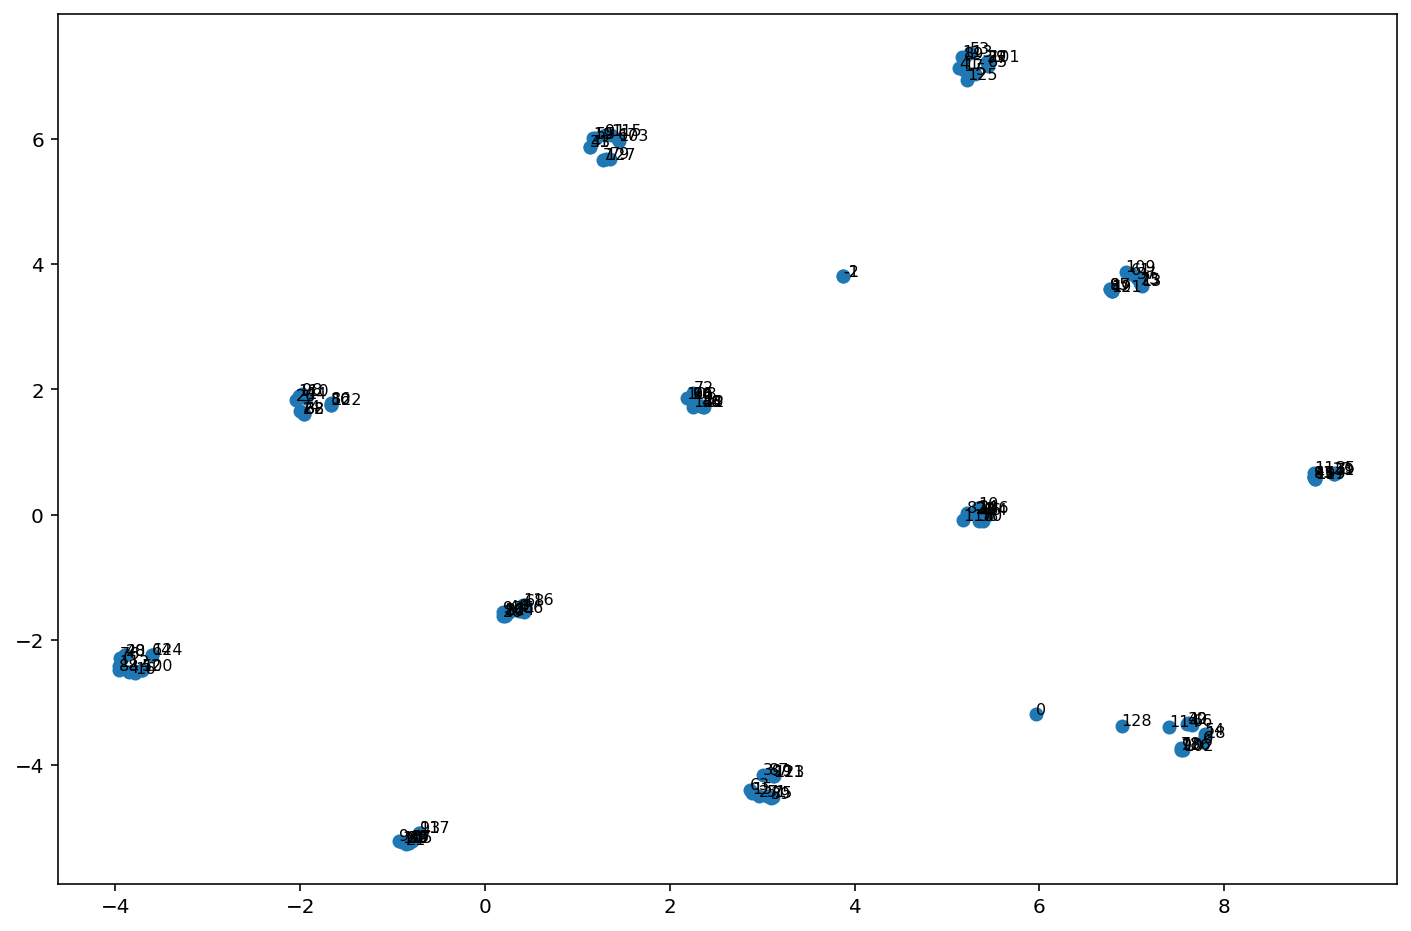

In [52]:
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(np.array(chroma_reconst_list))
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    ax.text(x , y , i-2,size = 8)

plt.show()

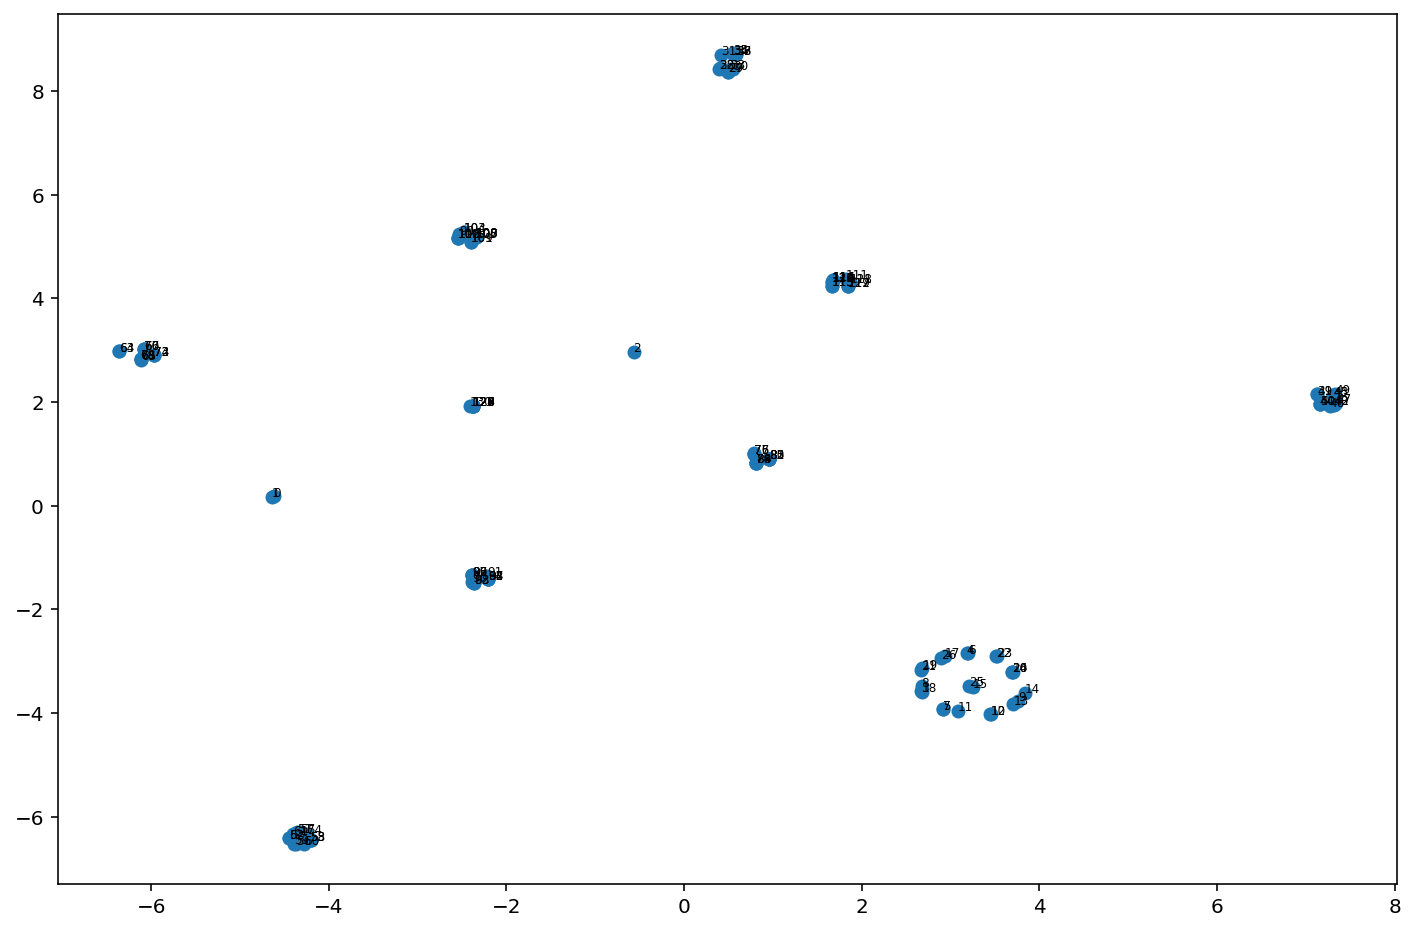

In [35]:
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(np.array(octaves_one_hot))
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 8)) 

plt.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    plt.text(x , y , i,size = 6)

plt.show()